In [1]:
%matplotlib widget
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

In [3]:
def backproject(C, R, f, x_c, y_c, width, height, k1, k2, k3, t1, t2):
    P_c = R @ P_w - R @ C
    
    if P_c[2] == 0:
        print('Divider is zero!')
        return False, np.ones((1, 2)) * np.nan
    
    p_n = [-P_c[0]/P_c[2], -P_c[1]/P_c[2]]

    r2 = p_n[0] * p_n[0] + p_n[1] * p_n[1]    
    rp = 1 + k1*r2 + k2*r2*r2 + k3*r2*r2*r2

    px = f * p_n[0] * rp
    py = f * p_n[1] * rp

    tx = t2 * (r2 + 2 * p_n[0] * p_n[0]) - 2 * t1 * p_n[0] * p_n[1];
    ty = - t1 * (r2 + 2 * p_n[1] * p_n[1]) + 2 * t2 * p_n[0] * p_n[1];
    
    x = px + f*tx + x_c + width/2.0;
    y = height/2.0 - (py + f*ty + y_c);

    if (x >= 0 and x <= width and y >= 0 and y <= height and 
        f*p_n[0] > -width/2.0*1.25 and f*p_n[0] < width/2.0*1.25 and
        f*p_n[1] > -height/2.0*1.25 and f*p_n[1] < height/2.0*1.25):
        return True, [x, y]
    else:
        return False, [x, y]

In [4]:
def triangulate(backprojection_data, views_rot, views_pos):

    if len(backprojection_data) < 2:
        print('Not enough observations!')
        return False, np.ones((1, 3)) * np.nan
    
    if backprojection_data.shape[1] < 3:
        print('Wrong backprojections array structure')
        return False, np.ones((1, 3)) * np.nan
    
    cam_indices = backprojection_data[:, 0].astype('int')
    img_pts = backprojection_data[:, 1:3]
    n_img_pts = img_pts.shape[0]

    A = np.zeros((n_img_pts*2, 3)) 
    b = np.zeros((n_img_pts*2, 1))
    for k in range(n_img_pts):
        cam_idx = cam_indices[k]
        R = views_rot[cam_idx]
        C = views_pos[cam_idx]
        img_pt = img_pts[k, :]

        x_i = img_pt[0] - x_c - width/2.0;
        y_i = -img_pt[1] - y_c + height/2.0;
        z_i = -f
        p_i = np.array([x_i, y_i, z_i]).T
        p_i_w = R.T @ p_i

        x_n_w = p_i_w[0] / p_i_w[2]
        y_n_w = p_i_w[1] / p_i_w[2]

        A[k*2, :] = [-1, 0, x_n_w]
        b[k*2] = -C[0] + x_n_w*C[2];

        A[k*2+1, :] = [0, -1, y_n_w]
        b[k*2 + 1] = -C[1] + y_n_w*C[2];

    #P_hat = np.linalg.inv((A.T @ A)) @ A.T @ b
    P_hat = np.linalg.solve(A.T @ A, A.T @ b)
              
    return True, P_hat.T.squeeze(0)

# Photo network

In [31]:
bundle_mean_offset = np.array([540697.72, 126932.555, 369.506])
bundle_data_str = '{"camera":{"focal_length":7596.96,"xo":17.69947914475496,"yo":-27.00910054427447,"pixel_width":7952,"pixel_height":5304,"k1":-0.0005397311277383503,"k2":0.04760033270021068,"k3":-0.08316522198836573,"t1":0.0011216462813948777,"t2":0.0001296026644894056},"images":[{"name":"MCC_Flight_01_00002.JPG","position":{"x":83.10739931747,"y":-1.3883533553999954,"z":1.5166797457400027},"rotation":[[0.81034123,-0.5768362,-0.10299077],[0.56965571,0.81670337,-0.09213019],[0.13725694,0.01598761,0.99040645]],"reconstructed":true},{"name":"MCC_Flight_01_00003.JPG","position":{"x":93.96891865296,"y":22.560211466479995,"z":0.31734358769999976},"rotation":[[0.77168072,-0.63448042,-0.04408472],[0.62802538,0.7711089,-0.10476251],[0.10046388,0.05315688,0.99351968]],"reconstructed":true},{"name":"MCC_Flight_01_00004.JPG","position":{"x":105.54738156557,"y":46.00339197029001,"z":-0.6063069580100007},"rotation":[[0.82810571,-0.56053818,0.00615497],[0.55984027,0.82641414,-0.06015434],[0.02863225,0.05325995,0.99817011]],"reconstructed":true},{"name":"MCC_Flight_01_00005.JPG","position":{"x":116.79384905957,"y":69.54891712517001,"z":0.07147869744999827},"rotation":[[0.79801155,-0.60248014,-0.01397317],[0.59641779,0.79288086,-0.12500303],[0.0863909,0.09142001,0.99205796]],"reconstructed":true},{"name":"MCC_Flight_01_00006.JPG","position":{"x":129.4393155429,"y":92.44797436368,"z":-0.9971768753399999},"rotation":[[0.70190633,-0.64934001,-0.29272011],[0.64928782,0.75227274,-0.11185278],[0.29283584,-0.11154942,0.94963356]],"reconstructed":true},{"name":"MCC_Flight_01_00007.JPG","position":{"x":96.34770125422,"y":113.89938032352,"z":-3.810952959960001},"rotation":[[-0.9749278,0.1790578,-0.13211392],[-0.18538465,-0.98196343,0.03715306],[-0.12307849,0.06071344,0.99053802]],"reconstructed":true},{"name":"MCC_Flight_01_00008.JPG","position":{"x":83.9137840257,"y":89.54935936770002,"z":-2.34611686743},"rotation":[[-0.96436142,0.25880971,0.05499621],[-0.25766739,-0.96585474,0.02705812],[0.06012125,0.01192308,0.99811987]],"reconstructed":true},{"name":"MCC_Flight_01_00009.JPG","position":{"x":72.4380656002,"y":65.97977537019,"z":-0.8445464587700006},"rotation":[[-0.98777064,0.15071172,0.03993913],[-0.15099545,-0.98852567,-0.00416811],[0.03885267,-0.01014776,0.99919342]],"reconstructed":true},{"name":"MCC_Flight_01_00010.JPG","position":{"x":61.78204224872,"y":42.28244980108,"z":-0.5597665034199999},"rotation":[[-0.99324042,0.1114719,-0.0323648],[-0.11126346,-0.9937573,-0.00817707],[-0.03307427,-0.00452077,0.99944267]],"reconstructed":true},{"name":"MCC_Flight_01_00011.JPG","position":{"x":50.796641855640004,"y":18.60111012366,"z":-0.5788932892400002},"rotation":[[-0.98310491,0.18180315,0.02126851],[-0.18189587,-0.98331464,-0.00249332],[0.02046034,-0.00631985,0.99977069]],"reconstructed":true},{"name":"MCC_Flight_01_00012.JPG","position":{"x":39.77649682848,"y":-4.941969077489999,"z":-0.47465600256},"rotation":[[-0.98788206,0.15433027,0.01646802],[-0.15462449,-0.98780195,-0.01840049],[0.01342739,-0.02072387,0.99969507]],"reconstructed":true},{"name":"MCC_Flight_01_00013.JPG","position":{"x":29.172033441280004,"y":-28.24187935392,"z":0.13404558658},"rotation":[[-0.98670411,0.16180896,-0.01525955],[-0.16126738,-0.98639886,-0.03178226],[-0.02019466,-0.02889882,0.99937832]],"reconstructed":true},{"name":"MCC_Flight_01_00014.JPG","position":{"x":18.23456306612,"y":-51.97537424172,"z":0.6019366691199993},"rotation":[[-0.98574088,0.16511518,-0.03243299],[-0.16238482,-0.98395634,-0.07389921],[-0.04411453,-0.06757885,0.99673818]],"reconstructed":true},{"name":"MCC_Flight_01_00015.JPG","position":{"x":7.100190418400002,"y":-76.19196779762,"z":0.7247388889799989},"rotation":[[-0.97016157,0.24238716,0.005915],[-0.24182199,-0.9655557,-0.09604332],[-0.01756841,-0.09460792,0.99535958]],"reconstructed":true},{"name":"MCC_Flight_01_00016.JPG","position":{"x":-3.2091757436800004,"y":-99.09174939209,"z":0.1832076888499999},"rotation":[[-0.97520701,0.22090857,-0.01306483],[-0.21924679,-0.97251054,-0.07844804],[-0.03003553,-0.07363865,0.99683259]],"reconstructed":true},{"name":"MCC_Flight_01_00017.JPG","position":{"x":-13.781601393939997,"y":-122.74326586259001,"z":-0.9653749458799998},"rotation":[[-0.95285654,0.18241998,0.24246106],[-0.20396235,-0.97670257,-0.06671918],[0.22464143,-0.11302674,0.96786424]],"reconstructed":true},{"name":"MCC_Flight_01_00018.JPG","position":{"x":-19.953178408479996,"y":-147.36566093603003,"z":-1.4091190752700018},"rotation":[[-0.96919272,-0.10878997,0.2209756],[0.092006,-0.99213187,-0.08490734],[0.228474,-0.0619605,0.97157631]],"reconstructed":true},{"name":"MCC_Flight_01_00019.JPG","position":{"x":-60.784510082080004,"y":-130.36786648088,"z":-2.68383929544},"rotation":[[0.8472586,-0.5303978,-0.02882764],[0.53068307,0.84756594,0.00272938],[0.02298567,-0.01761083,0.99958067]],"reconstructed":true},{"name":"MCC_Flight_01_00020.JPG","position":{"x":-50.25672415919,"y":-105.96207473889001,"z":-1.7795941138400013},"rotation":[[0.84550237,-0.53335676,-0.02561842],[0.53114214,0.84498609,-0.06234206],[0.05489777,0.03910333,0.997726]],"reconstructed":true},{"name":"MCC_Flight_01_00021.JPG","position":{"x":-39.31184641411,"y":-82.30948348608001,"z":-1.1593008225099997},"rotation":[[0.84431428,-0.53563957,-0.01495465],[0.53338352,0.84277701,-0.07231141],[0.05133629,0.05307699,0.99726998]],"reconstructed":true},{"name":"MCC_Flight_01_00022.JPG","position":{"x":-28.4266756578,"y":-59.31664715067,"z":-2.36842743613},"rotation":[[0.78628321,-0.61778783,-0.00984396],[0.61669513,0.78567373,-0.04902974],[0.03802411,0.03248054,0.99874881]],"reconstructed":true},{"name":"MCC_Flight_01_00023.JPG","position":{"x":-17.309808088549996,"y":-36.03336170281,"z":-2.3318634653},"rotation":[[0.75721603,-0.65309632,-0.00943801],[0.65225004,0.75684129,-0.04196601],[0.03455093,0.02562139,0.99907446]],"reconstructed":true},{"name":"MCC_Flight_01_00024.JPG","position":{"x":-6.14956774443,"y":-12.590786464419999,"z":-1.28745313282},"rotation":[[0.77179614,-0.63333574,-0.05671474],[0.62823953,0.77327152,-0.08582688],[0.09821312,0.03061042,0.99469452]],"reconstructed":true},{"name":"MCC_Flight_01_00025.JPG","position":{"x":4.67192787628,"y":10.98027093868,"z":-1.61953883036},"rotation":[[0.80930452,-0.5869705,0.02217745],[0.58687216,0.80643146,-0.07245257],[0.02464292,0.07165152,0.99712526]],"reconstructed":true},{"name":"MCC_Flight_01_00027.JPG","position":{"x":26.352242904449998,"y":58.33984052699,"z":-4.04966572915},"rotation":[[0.79094721,-0.61188311,0.00125193],[0.61186771,0.7909391,0.00576538],[-0.00451794,-0.00379409,0.9999826]],"reconstructed":true},{"name":"MCC_Flight_01_00028.JPG","position":{"x":36.96040563158,"y":82.42612198622,"z":-2.2513549526500003},"rotation":[[0.81923108,-0.56604724,-0.09192913],[0.5609882,0.8243003,-0.07629718],[0.11896502,0.01093386,0.99283824]],"reconstructed":true},{"name":"MCC_Flight_01_00029.JPG","position":{"x":48.12687750652,"y":105.82714233602,"z":-0.05708067268000161},"rotation":[[0.8361283,-0.54267439,0.07996232],[0.5484411,0.82437497,-0.14006523],[0.01009088,0.16096712,0.98690818]],"reconstructed":true},{"name":"MCC_Flight_01_00030.JPG","position":{"x":58.699980032380005,"y":129.33877201637003,"z":0.18929230054999646},"rotation":[[0.84214624,-0.50677053,-0.1843186],[0.47527966,0.85901627,-0.19026375],[0.25475274,0.07262703,0.96427504]],"reconstructed":true},{"name":"MCC_Flight_01_00031.JPG","position":{"x":74.42521235379998,"y":149.87227242589,"z":-1.7782993247699999},"rotation":[[0.49071435,-0.86985957,0.05043566],[0.867709,0.48259627,-0.11908791],[0.0792497,0.10220162,0.99160189]],"reconstructed":true},{"name":"MCC_Flight_01_00032.JPG","position":{"x":33.954899538359996,"y":163.89958254244002,"z":-0.307226911220002},"rotation":[[-0.91507777,0.39628165,-0.07478991],[-0.38499858,-0.91364782,-0.13047508],[-0.12003652,-0.09060084,0.98862668]],"reconstructed":true},{"name":"MCC_Flight_01_00033.JPG","position":{"x":21.0436970075,"y":141.23445400428,"z":0.6077741616100013},"rotation":[[-0.96817346,0.23232556,0.09308594],[-0.24431589,-0.95801329,-0.15006761],[0.05431303,-0.16803385,0.98428386]],"reconstructed":true},{"name":"MCC_Flight_01_00034.JPG","position":{"x":10.050225178470003,"y":116.99561955492001,"z":1.2267308610000007},"rotation":[[-0.97843709,0.20328418,-0.03655684],[-0.19781443,-0.97319935,-0.11727097],[-0.05941642,-0.10751079,0.99242688]],"reconstructed":true},{"name":"MCC_Flight_01_00035.JPG","position":{"x":-0.6095744040299999,"y":93.20479109617001,"z":1.69486880523},"rotation":[[-0.95594557,0.29275125,-0.02155847],[-0.28711397,-0.94776839,-0.13892677],[-0.06110342,-0.12661669,0.99006797]],"reconstructed":true},{"name":"MCC_Flight_01_00036.JPG","position":{"x":-11.74049362554,"y":69.68190398578,"z":1.6412159592299995},"rotation":[[-0.9924335,0.1207471,-0.02226851],[-0.11819506,-0.9886202,-0.09305927],[-0.03325174,-0.08972311,0.99541152]],"reconstructed":true},{"name":"MCC_Flight_01_00037.JPG","position":{"x":-22.50598139181,"y":46.10275115989,"z":1.163079411060001},"rotation":[[-0.98562483,0.16061027,0.0524217],[-0.16640961,-0.97648916,-0.13702832],[0.02918106,-0.14378199,0.98917906]],"reconstructed":true},{"name":"MCC_Flight_01_00038.JPG","position":{"x":-33.0956029765,"y":22.041837901610002,"z":-0.33804655541999995},"rotation":[[-0.9749704,0.21898189,-0.0384662],[-0.21751552,-0.97528018,-0.03893028],[-0.04604035,-0.02958888,0.99850127]],"reconstructed":true},{"name":"MCC_Flight_01_00039.JPG","position":{"x":-43.87464388570999,"y":-1.5927713178599994,"z":-0.5537127837500001},"rotation":[[-0.97633353,0.21529253,0.02054176],[-0.21580373,-0.97605838,-0.02718084],[0.01419813,-0.03097056,0.99941945]],"reconstructed":true},{"name":"MCC_Flight_01_00040.JPG","position":{"x":-54.510113246260005,"y":-25.446753098600006,"z":0.7019744014299988},"rotation":[[-0.97603594,0.15194383,-0.15577841],[-0.13758293,-0.98550835,-0.09921808],[-0.1685965,-0.07540796,0.98279645]],"reconstructed":true},{"name":"MCC_Flight_01_00041.JPG","position":{"x":-65.35699809863,"y":-48.841986456540006,"z":0.4716067997199971},"rotation":[[-0.97886972,0.20396636,-0.01455338],[-0.20047715,-0.97127258,-0.1282127],[-0.04028638,-0.12258591,0.99163991]],"reconstructed":true},{"name":"MCC_Flight_01_00042.JPG","position":{"x":-76.40045050791001,"y":-72.32857366233,"z":-0.6613372341600026},"rotation":[[-0.95221411,0.29744105,-0.06940544],[-0.2862134,-0.9482894,-0.1372192],[-0.10663107,-0.11079729,0.98810616]],"reconstructed":true},{"name":"MCC_Flight_01_00043.JPG","position":{"x":-87.82270648387,"y":-96.11138884092,"z":-2.3685487168799995},"rotation":[[-0.96173406,0.27276641,0.0258088],[-0.27398454,-0.95755316,-0.08957915],[0.00027911,-0.09322253,0.99564526]],"reconstructed":true},{"name":"MCC_Flight_01_00044.JPG","position":{"x":-96.63970507004,"y":-120.12193572817999,"z":-1.9152292782400007},"rotation":[[-0.96508343,0.00046369,0.26194227],[-0.02811694,-0.99440419,-0.10183198],[0.26042927,-0.10564138,0.95969604]],"reconstructed":true},{"name":"MCC_Flight_01_00045.JPG","position":{"x":-101.16793741203999,"y":-145.1405188836,"z":-2.160231081439999},"rotation":[[-0.99041378,-0.13743765,0.01383635],[0.13389783,-0.97983525,-0.14830463],[0.03393998,-0.14503029,0.98884493]],"reconstructed":true},{"name":"MCC_Flight_01_00046.JPG","position":{"x":-139.18879784592002,"y":-119.73998083541,"z":-5.741218491100002},"rotation":[[0.78593322,-0.61745422,0.03254638],[0.6181204,0.78329303,-0.06617552],[0.015367,0.07212712,0.99727706]],"reconstructed":true},{"name":"MCC_Flight_01_00047.JPG","position":{"x":-127.63374036211,"y":-95.62691780691,"z":-6.33058333425},"rotation":[[0.80163236,-0.5977796,-0.00671605],[0.59736027,0.80140815,-0.03009464],[0.02337226,0.02011294,0.99952449]],"reconstructed":true},{"name":"MCC_Flight_01_00049.JPG","position":{"x":-105.75819455729,"y":-48.28598842580998,"z":-3.6516321231000015},"rotation":[[0.76680891,-0.64063655,-0.039861],[0.63597836,0.76669618,-0.08779803],[0.08680791,0.04197358,0.99534045]],"reconstructed":true},{"name":"MCC_Flight_01_00050.JPG","position":{"x":-95.36473636784,"y":-24.77993105843001,"z":-3.0539439972399998},"rotation":[[0.8318309,-0.55496983,0.008114],[0.55215098,0.82594205,-0.11379376],[0.05645041,0.09913732,0.99347126]],"reconstructed":true}]}'
bundle_data = json.loads(bundle_data_str)

camera = bundle_data['camera']
f = camera['focal_length']
x_c = camera['xo']
y_c = camera['yo']
width = camera['pixel_width']
height = camera['pixel_height']
k1 = camera['k1']
k2 = camera['k2']
k3 = camera['k3']
t1 = camera['t1']
t2 = camera['t2']

views = bundle_data['images']
n_views = len(views)
views_pos = np.array([[view['position']['x'], view['position']['y'], view['position']['z']] for view in views])
views_rot = np.array([view['rotation'] for view in views])

# Problem definiation

In [179]:
if False: # Synthetic testing: backrpojection computed
    points_gt = np.array([[540825.856998-50, 127060.950000-50, 276.267000], 
                          [540704.787994, 126897.916000, 270.622000],
                          [540684.070007, 126880.800003, 267.571000]])
    points_gt = points_gt - bundle_mean_offset

    R_gt = Rotation.from_euler('ZYX', [10.0, 5.0, -3.0], degrees=True).as_matrix()
    t_gt = [1, -2, -38]
    points_lidar = (R_gt @ points_gt.T).T + t_gt

    backprojections = []
    for i in range(points_gt.shape[0]):
        P_w = points_gt[i, :]
        backprojections.append([]);
        for k in range(n_views):
            R = views_rot[k]
            C = views_pos[k]
            is_on_image, pt = backproject(C, R, f, x_c, y_c, width, height, k1, k2, k3, t1, t2)
            #is_on_image, pt = backproject(C, R, f, x_c, y_c, width, height, 0, 0, 0, 0, 0)
            if is_on_image:
                backprojections[i].append([k, pt[0], pt[1]])

else: # Real appearances
    
    gcp_str = '[{"XYZ":[540704.79,126897.92,270.62],"appearances":[["MCC_Flight_01_00012.JPG",5856,647],["MCC_Flight_01_00013.JPG",5695,1968],["MCC_Flight_01_00014.JPG",5412,3106],["MCC_Flight_01_00015.JPG",4886,4300],["MCC_Flight_01_00023.JPG",4727,1457],["MCC_Flight_01_00024.JPG",5471,2630],["MCC_Flight_01_00025.JPG",5107,4248],["MCC_Flight_01_00039.JPG",861,1305],["MCC_Flight_01_00040.JPG",2088,2041],["MCC_Flight_01_00041.JPG",639,3419],["MCC_Flight_01_00042.JPG",1161,4982]]},{"XYZ":[540825.86,127060.95,276.27],"appearances":[["MCC_Flight_01_00006.JPG",4517,607],["MCC_Flight_01_00007.JPG",3673,4014]]},{"XYZ":[540684.4,126880.90000000001,267.57],"appearances":[["MCC_Flight_01_00013.JPG",6652,860],["MCC_Flight_01_00014.JPG",6380,1977],["MCC_Flight_01_00015.JPG",5739,3112],["MCC_Flight_01_00016.JPG",5569,4650],["MCC_Flight_01_00022.JPG",4104,1463],["MCC_Flight_01_00023.JPG",4452,2957],["MCC_Flight_01_00024.JPG",5136,4052],["MCC_Flight_01_00039.JPG",1855,152],["MCC_Flight_01_00040.JPG",3040,961],["MCC_Flight_01_00041.JPG",1563,2267],["MCC_Flight_01_00042.JPG",1925,3814]]},{"XYZ":[540653.43,126904.21,270.62],"appearances":[["MCC_Flight_01_00015.JPG",7719,3975],["MCC_Flight_01_00022.JPG",1862,1476],["MCC_Flight_01_00023.JPG",2242,3102],["MCC_Flight_01_00024.JPG",2986,4140],["MCC_Flight_01_00039.JPG",3834,1052],["MCC_Flight_01_00040.JPG",4880,1971],["MCC_Flight_01_00041.JPG",3467,3206],["MCC_Flight_01_00042.JPG",3826,4598],["MCC_Flight_01_00050.JPG",6301,259]]}]'
    gcps = json.loads(gcp_str)
    
    backprojections = []
    points_lidar = []
    for gcp_idx, gcp in enumerate(gcps):
        #if gcp_idx == 1:
        #    continue
        XYZ = gcp['XYZ']
        points_lidar.append(XYZ)
        backprojections.append([])
        for app in gcp['appearances']:
            image_name = app[0]
            
            image_idx = None
            for idx, view in enumerate(views):
                if view['name'] == image_name:
                    image_idx = idx
                    break
                    
            if image_idx != None:
                last_idx = len(backprojections)-1
                backprojections[last_idx].append([image_idx, app[1], app[2]])
    points_lidar = np.array(points_lidar) - bundle_mean_offset
    points_gt = None

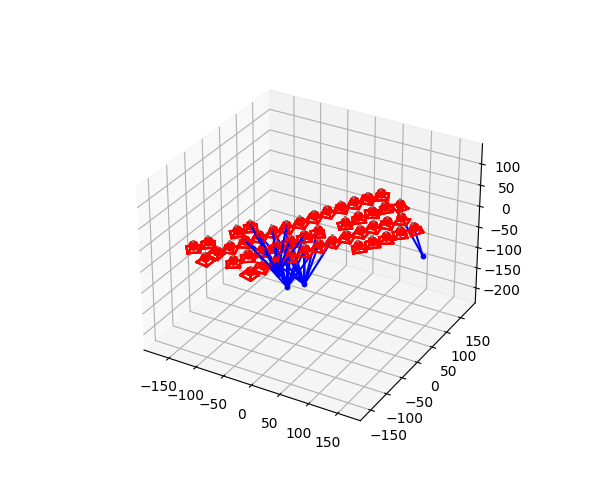

In [180]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.scatter3D(views_pos[:,0], views_pos[:,1], views_pos[:,2], c='r', s=10)
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='r', s=10)
points_vis = points_lidar
for i in range(points_vis.shape[0]):
    P_w = points_vis[i, :]
    ax.scatter3D(P_w[0], P_w[1], P_w[2], c='b', s=10)
    for k in range(n_views):
        plot_fustrum(ax, views_pos[k], views_rot[k], f=-1.0, scale=10)
    for backprojection in backprojections[i]:
        cam_idx = backprojection[0]
        ax.plot3D([P_w[0], views_pos[cam_idx,0]], 
                     [P_w[1], views_pos[cam_idx,1]], 
                     [P_w[2], views_pos[cam_idx, 2]], 'b-')
set_3d_axes_equal(ax)

# Solution #1

In [182]:
points_hat = []
for k, backprojection_data in enumerate(backprojections):
    result, P_hat = triangulate(np.array(backprojection_data), views_rot, views_pos)
    points_hat.append(P_hat)
    
    if points_gt is not None:
        print('Check triangulation (~=0): ', np.linalg.norm(P_hat - points_gt[k]))   
        
points_hat = np.array(points_hat)

print('Points to lidar: ')   
print(points_hat - points_lidar)


Points to lidar: 
[[ -6.01727256   2.88720512 -31.90015453]
 [ -7.22228129  -1.48935512 -34.41331197]
 [ -5.68167026   3.43390111 -32.00953461]
 [ -4.76194092   3.0407225  -31.95642823]]


In [199]:
def find_rigid_transformation(pts_model, pts_target):
    cog_model = np.mean(pts_model, axis=0)
    cog_target = np.mean(pts_target, axis=0)

    pts_model_cog = pts_model - cog_model
    pts_target_cog = pts_target - cog_target

    C = pts_model_cog.T @ pts_target_cog

    [U, S, V] = np.linalg.svd(C)
    V = V.T

    R_hat = V @ U.T
    t_hat = cog_target - R_hat @ cog_model

    s1 = 0
    s2 = 0
    for k in range(pts_model_cog.shape[0]):
        s1 += pts_model_cog[k].dot(pts_model_cog[k]) 
        s2 += pts_target_cog[k].dot(pts_target_cog[k]) 
    scale = np.sqrt(s2/s1)
    
    return True, R_hat, t_hat, scale

result, R_hat, t_hat, scale = find_rigid_transformation(points_lidar, points_hat) 
points_lidar_hat = (R_hat @ points_lidar.T).T + t_hat

res_svd = np.linalg.norm(points_lidar_hat - points_hat, axis=1)
print('Check transformation (if simulated then ~=0)', np.linalg.norm(res_svd))

print('Point set to point set distance:')
print('  before:', np.linalg.norm(points_lidar - points_hat))
print('  after: ', np.linalg.norm(points_lidar_hat - points_hat))

print('t_hat:', t_hat)

Check transformation (if simulated then ~=0) 4.169602896345325
Point set to point set distance:
  before: 66.50291488012043
  after:  4.169602896345324
t_hat: [ -5.55137657   3.15816182 -32.46319206]


In [162]:
print(points_lidar_hat - points_hat)

[[-0.20799681 -0.82417879 -0.21868533]
 [ 2.30957812  2.63116878  0.09365461]
 [-0.69023722 -1.23874681  0.15120128]
 [-1.41134409 -0.56824318 -0.02617056]]


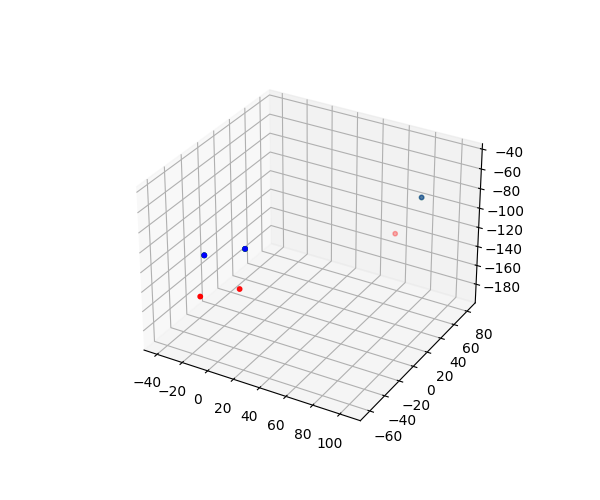

In [155]:
plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
if points_gt is not None:
    ax.scatter3D(points_gt[:, 0], points_gt[:, 1], points_gt[:, 2], c='g', s=10)
ax.scatter3D(points_hat[:, 0], points_hat[:, 1], points_hat[:, 2], c='g', s=10)
ax.scatter3D(points_lidar[:, 0], points_lidar[:, 1], points_lidar[:, 2], c='r', s=10)
ax.scatter3D(points_lidar_hat[:, 0], points_lidar_hat[:, 1], points_lidar_hat[:, 2], c='b', s=10)
set_3d_axes_equal(ax)

# Solution #2

$$
\min_{R,\mathbf{t}} \sum_i \frac{ \lVert d_i \times (C_i - (RP_i + t)) \lVert }{ \lVert d_i \lVert}
$$
where $C_i$ is the camera center, $d_i$ is the direction vector of ray corresponging to the $i$th image point and $P_i$ is the lidar point.